In [1]:
%run ../../_setup.py

import numpy as np
from netCDF4 import Dataset
from scipy.interpolate import griddata

import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from mpl_toolkits.axes_grid1 import AxesGrid
# from mpl_toolkits.axes_grid1 import ImageGrid

# from matplotlib.colorbar import ColorbarBase


In [2]:
savefig = True

In [3]:
# load ctd and gsw data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')

# load gem
input_file_gem = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gem.nc')
gem = Dataset(input_file_gem, 'r')
gem.variables.keys()

odict_keys(['t', 'SP', 'CT', 'pt', 'SA', 'sigma0', 'gamman'])

### Create Dynamic Height contours with the reference level (1494 dbar) considered as the level of 'no-motion'


In [4]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

# transect stations
transects = {1: list(reversed(range(2, 10))), 2: list(range(10, 18)), 3: list(reversed(range(18, 27))),
             4: list(range(26, 34)), 5: list(reversed(range(36, 46))), 6: list(range(46, 57)),
             7: list(reversed(range(56, 65))), 8: list(reversed(range(68, 76))), 9: list(range(76, 84)),
             10: list(reversed(range(84, 91))), 11: list([93, 92] + list(range(94, 101)))}

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


## Measurements, GEM field and anomaly for each transect

In [5]:
attr = {'pt' : ('Potential Temperature', cmo.cm.thermal, (2.25, 12.25), cmo.cm.balance, (-1, 1, 16)), 
        'CT' : ('Conservative Temperature', cmo.cm.thermal, (2, 12), cmo.cm.balance, (-1, 1, 16)), 
        'SA': ('Absolute Salinity', cmo.cm.haline, (34, 35), cmo.cm.delta, (-0.2, 0.2, 16)),
        'sigma0': ('Potential density', cmo.cm.dense, (26.4, 27.7), cmo.cm.curl, (-0.05, 0.05, 16)),
        'gamman': ('Neutral density', cmo.cm.dense, (26.35, 27.95), cmo.cm.diff_r, (-0.05, 0.05, 16))
       }

var = 'CT'
anomaly = ctd[var][:] - gem[var][:]

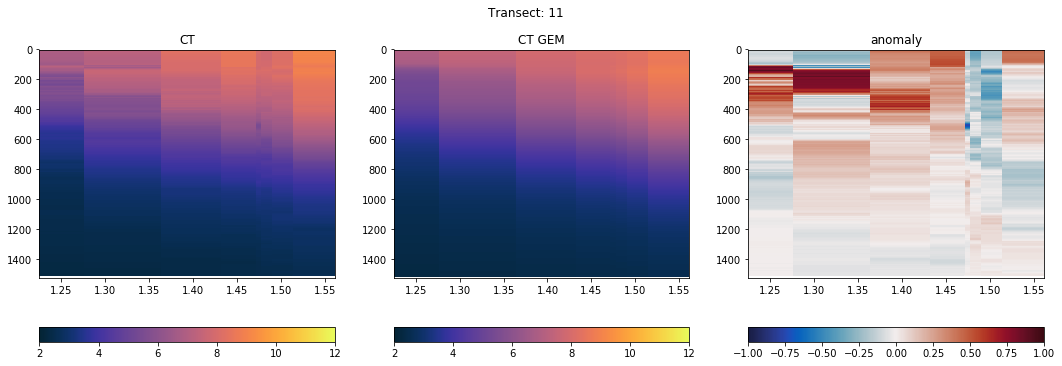

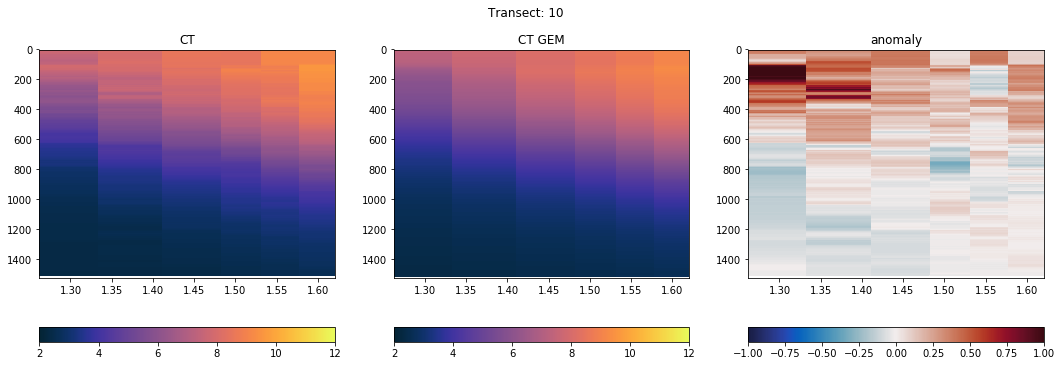

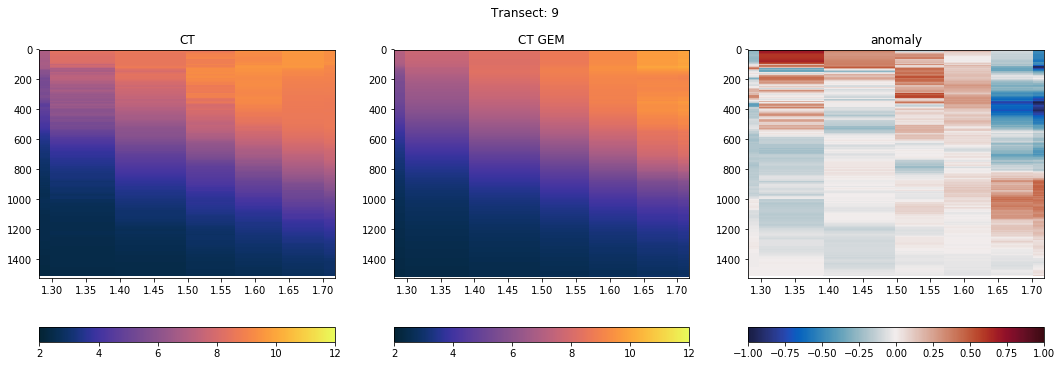

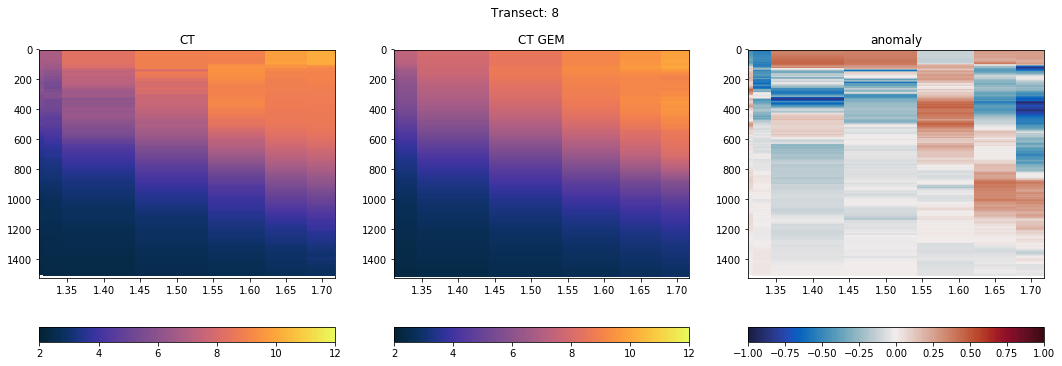

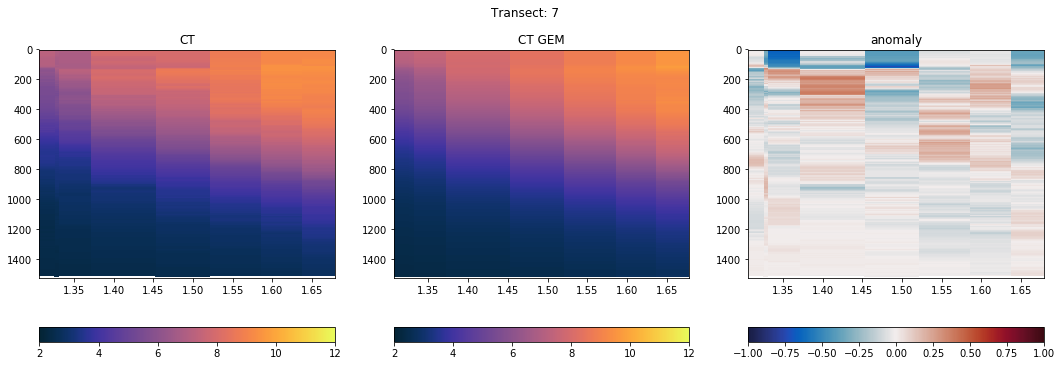

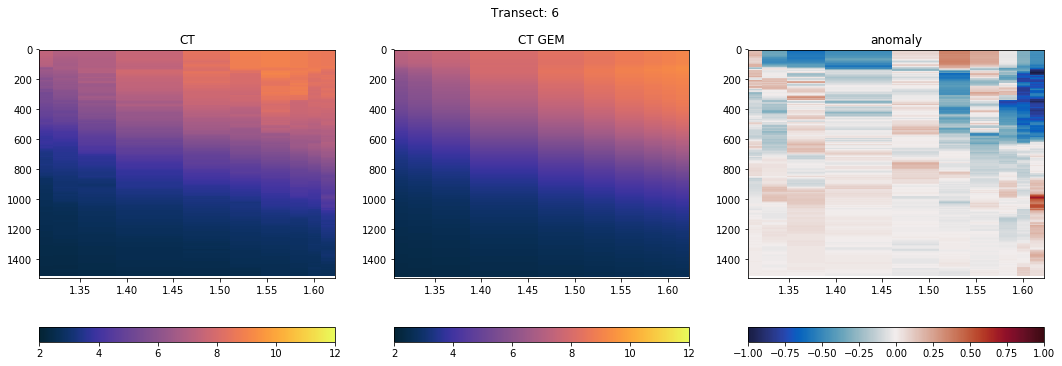

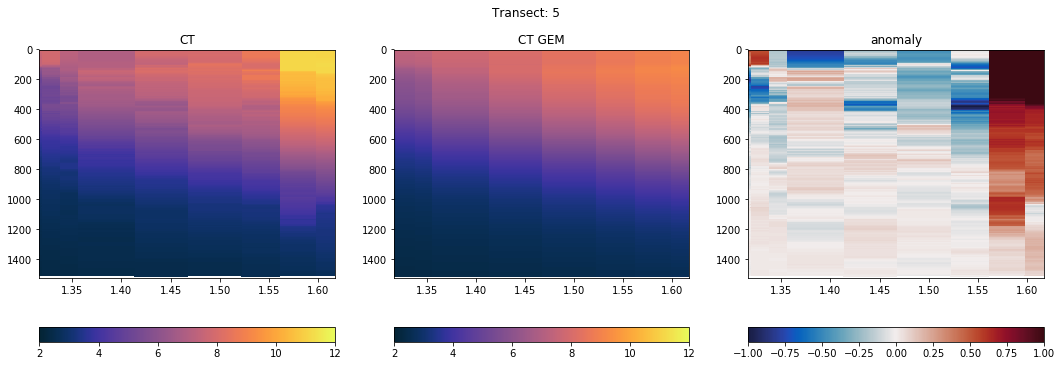

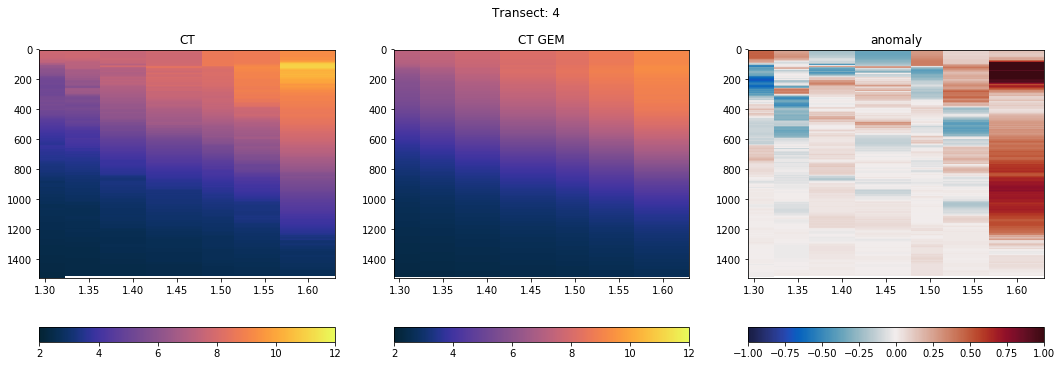

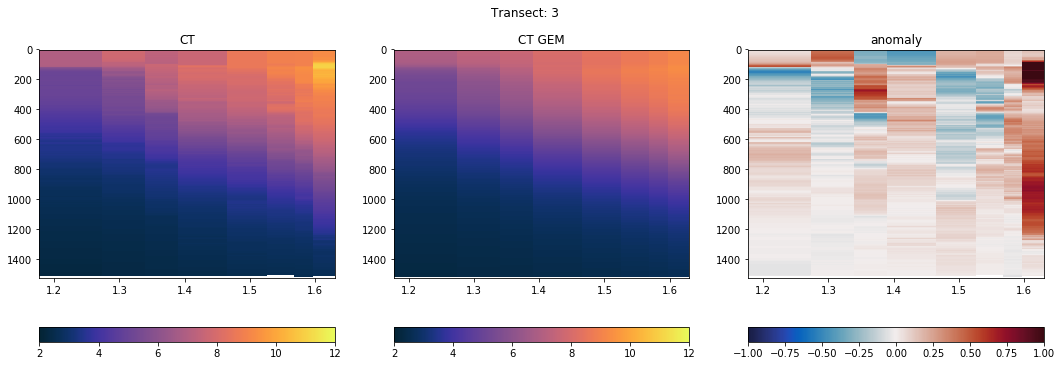

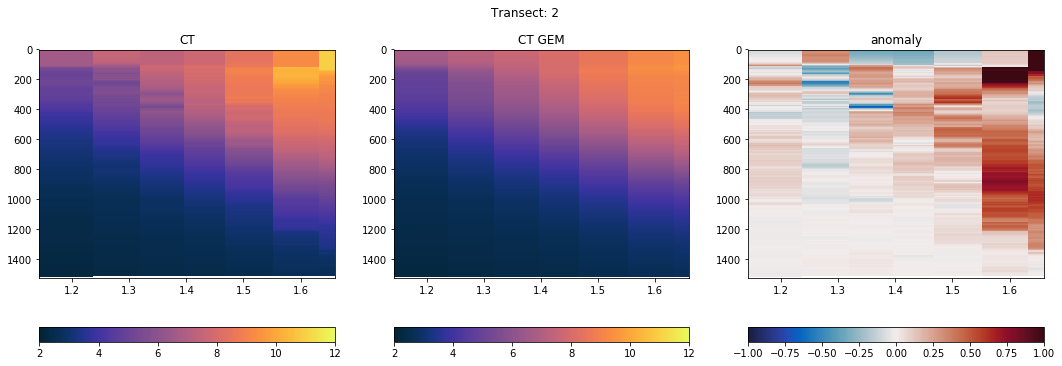

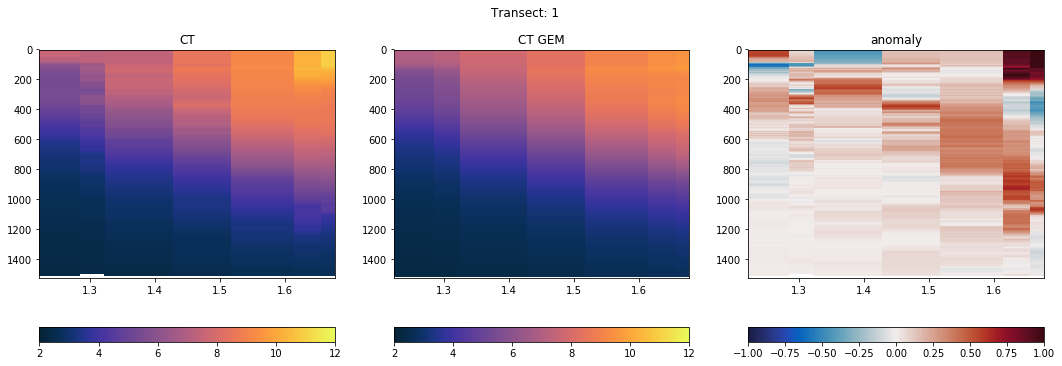

In [6]:
for transect in reversed(list(transects.keys())):
    stations = transects[transect]  
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    pcol = ax[0].pcolor(D[stations], ctd['p'], ctd[var][stations].T, 
                        cmap=attr[var][1], vmin=attr[var][2][0], vmax=attr[var][2][1])
    plt.colorbar(pcol, ax=ax[0], orientation='horizontal')
    
    pcol1 = ax[1].pcolor(D[stations], ctd['p'], gem[var][stations].T, 
                         cmap=attr[var][1], vmin=attr[var][2][0], vmax=attr[var][2][1])
    plt.colorbar(pcol1, ax=ax[1], orientation='horizontal')
    
#     pcol2 = ax[2].pcolor(D[stations], ctd['p'], ctd[var][stations].T - gem[var][stations].T, 
#                         cmap=attr[var][3], vmin=attr[var][4][0], vmax=attr[var][4][1])
    pcol2 = ax[2].pcolor(D[stations], ctd['p'], anomaly[stations].T,
                         cmap=attr[var][3], vmin=attr[var][4][0], vmax=attr[var][4][1])
    plt.colorbar(pcol2, ax=ax[2], orientation='horizontal')
   
    for axis in range(len(ax)):
        ax[axis].set_title({1: var + ' GEM', 2: 'anomaly'}.get(axis, var))
        ax[axis].invert_yaxis()
    fig.suptitle('Transect: %s' % transect)


## Anomaly for each transect (interpolated)

In [7]:
Di = np.linspace(np.nanmin(D), np.nanmax(D))
# DD, pp = np.meshgrid(Di, ctd['p'][:])
Dgrd, pgrd = np.meshgrid(Di, ctd['p'][:])

In [8]:
# initialise plots

fs_small=20
fs_large=22

plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)

keys = list(transects.keys())
keys.insert(4, 4)


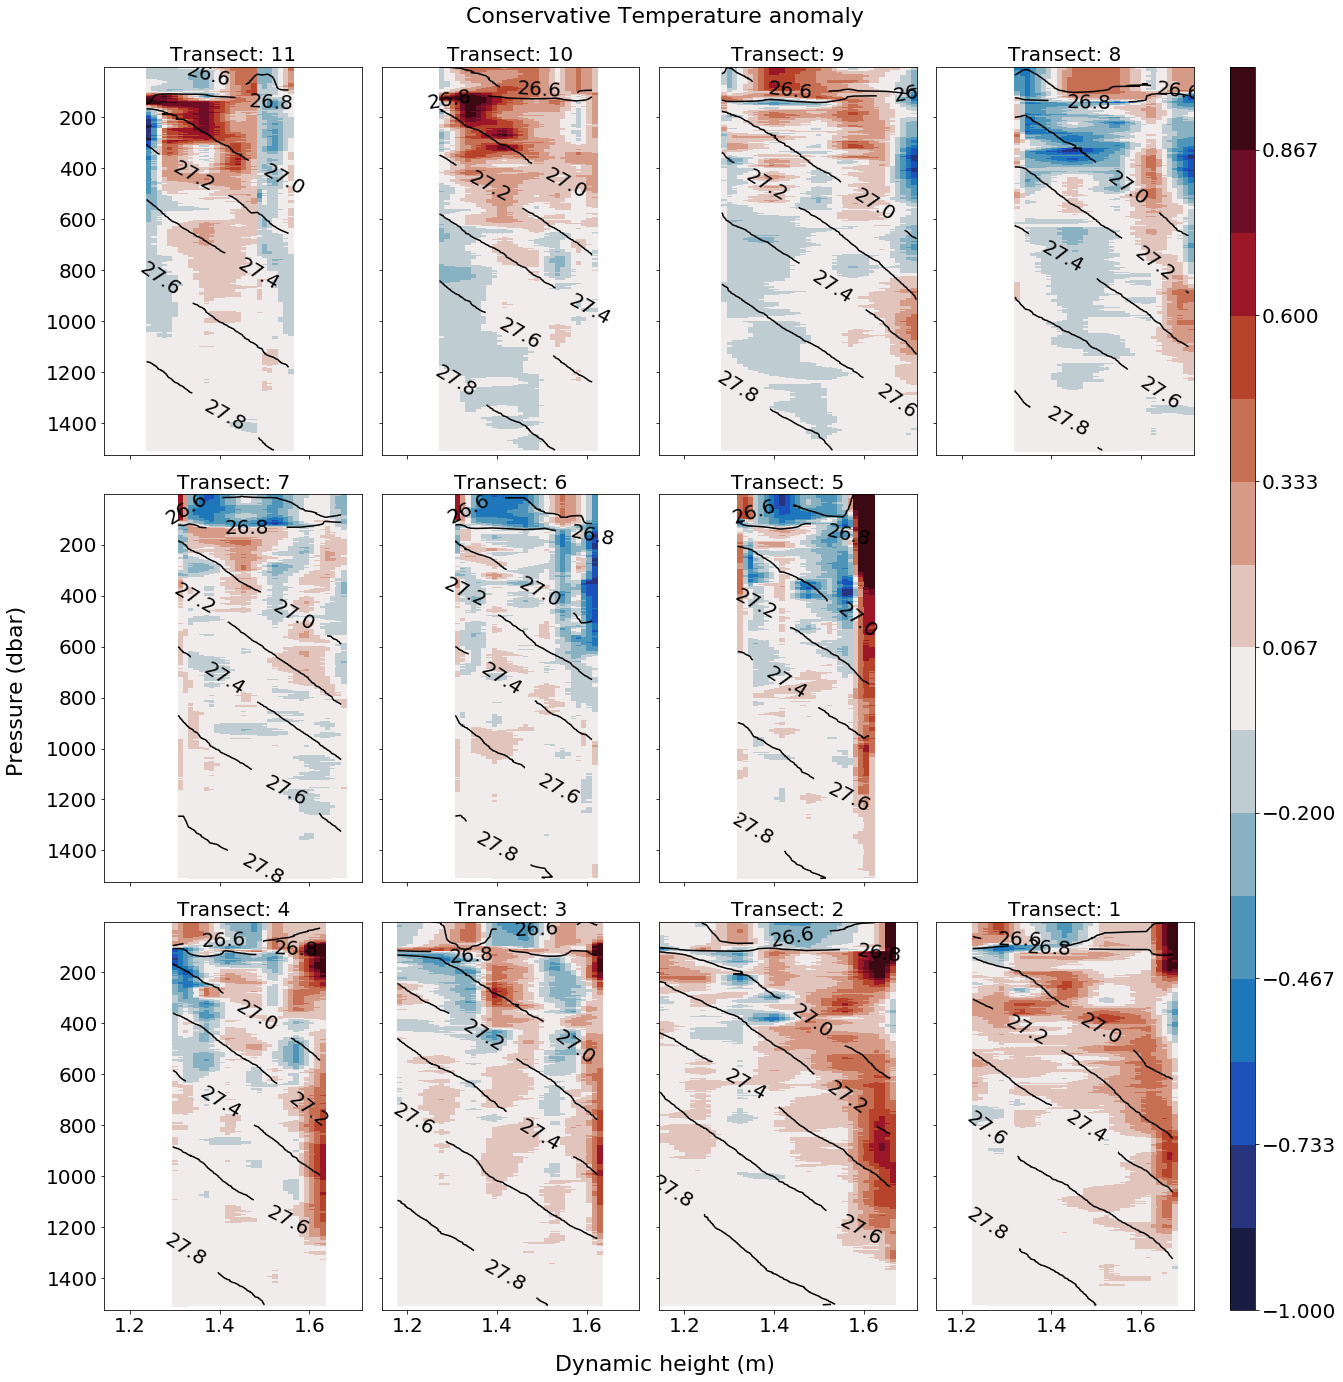

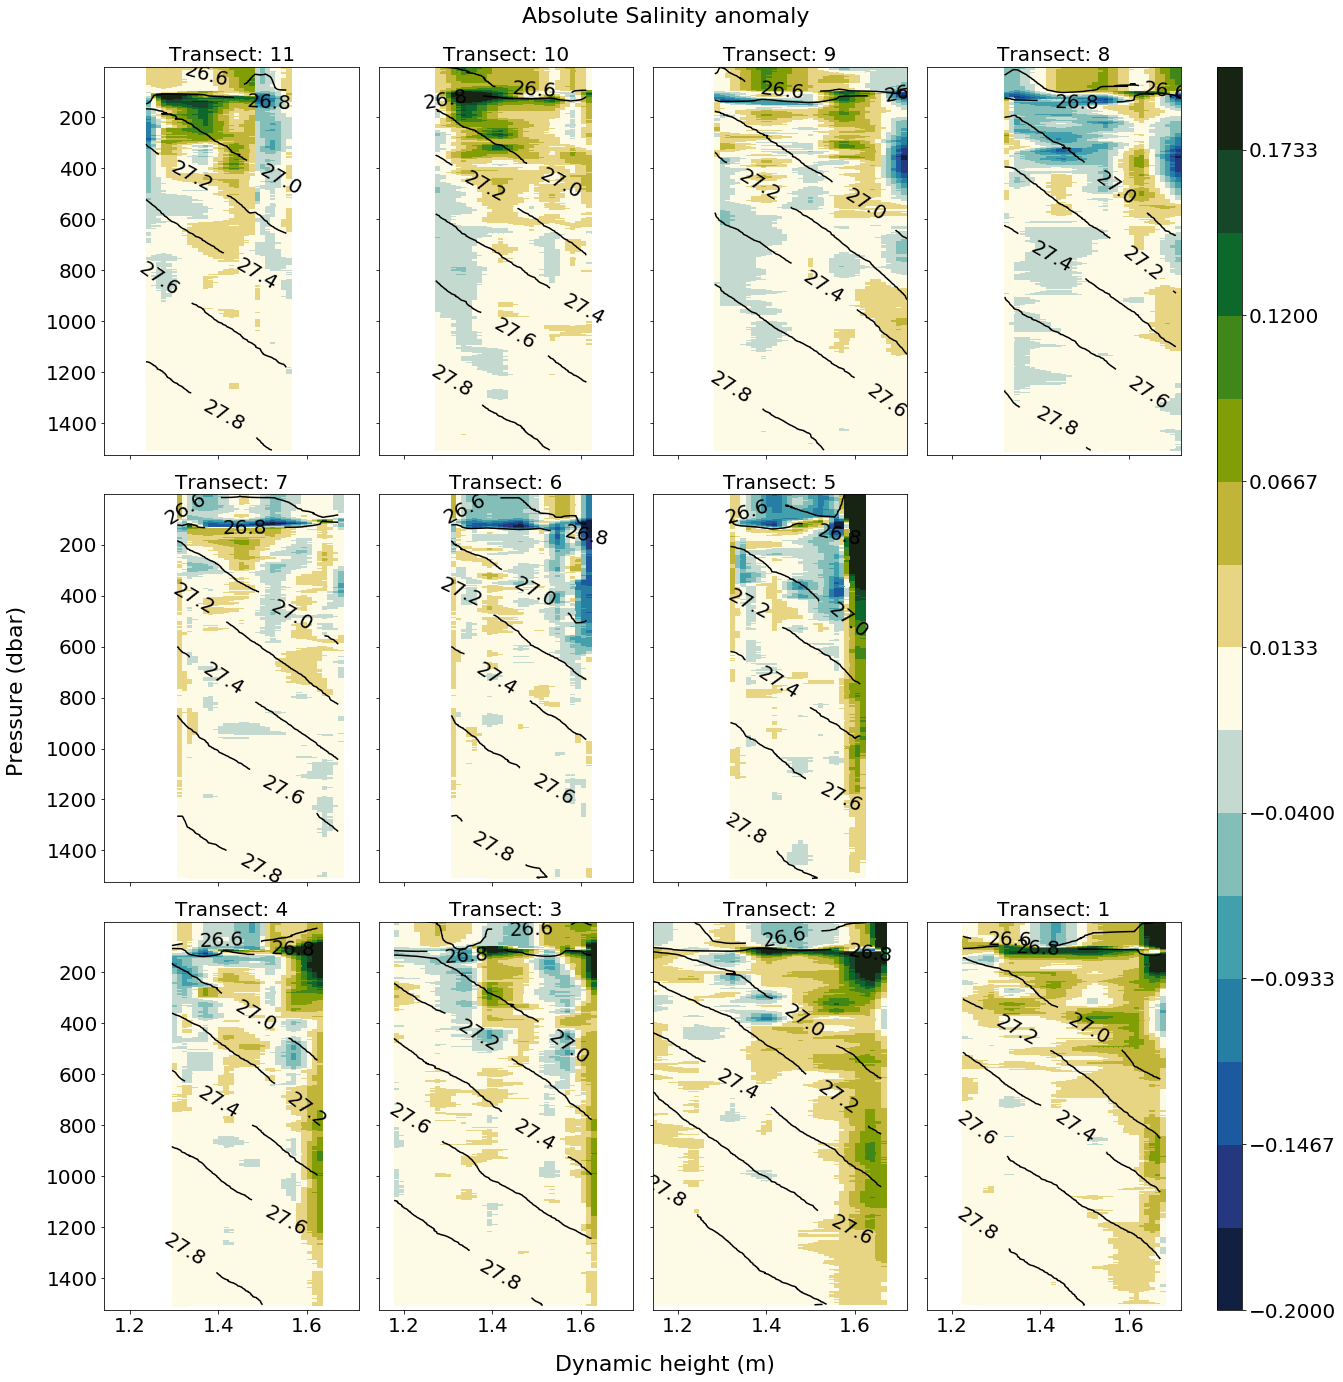

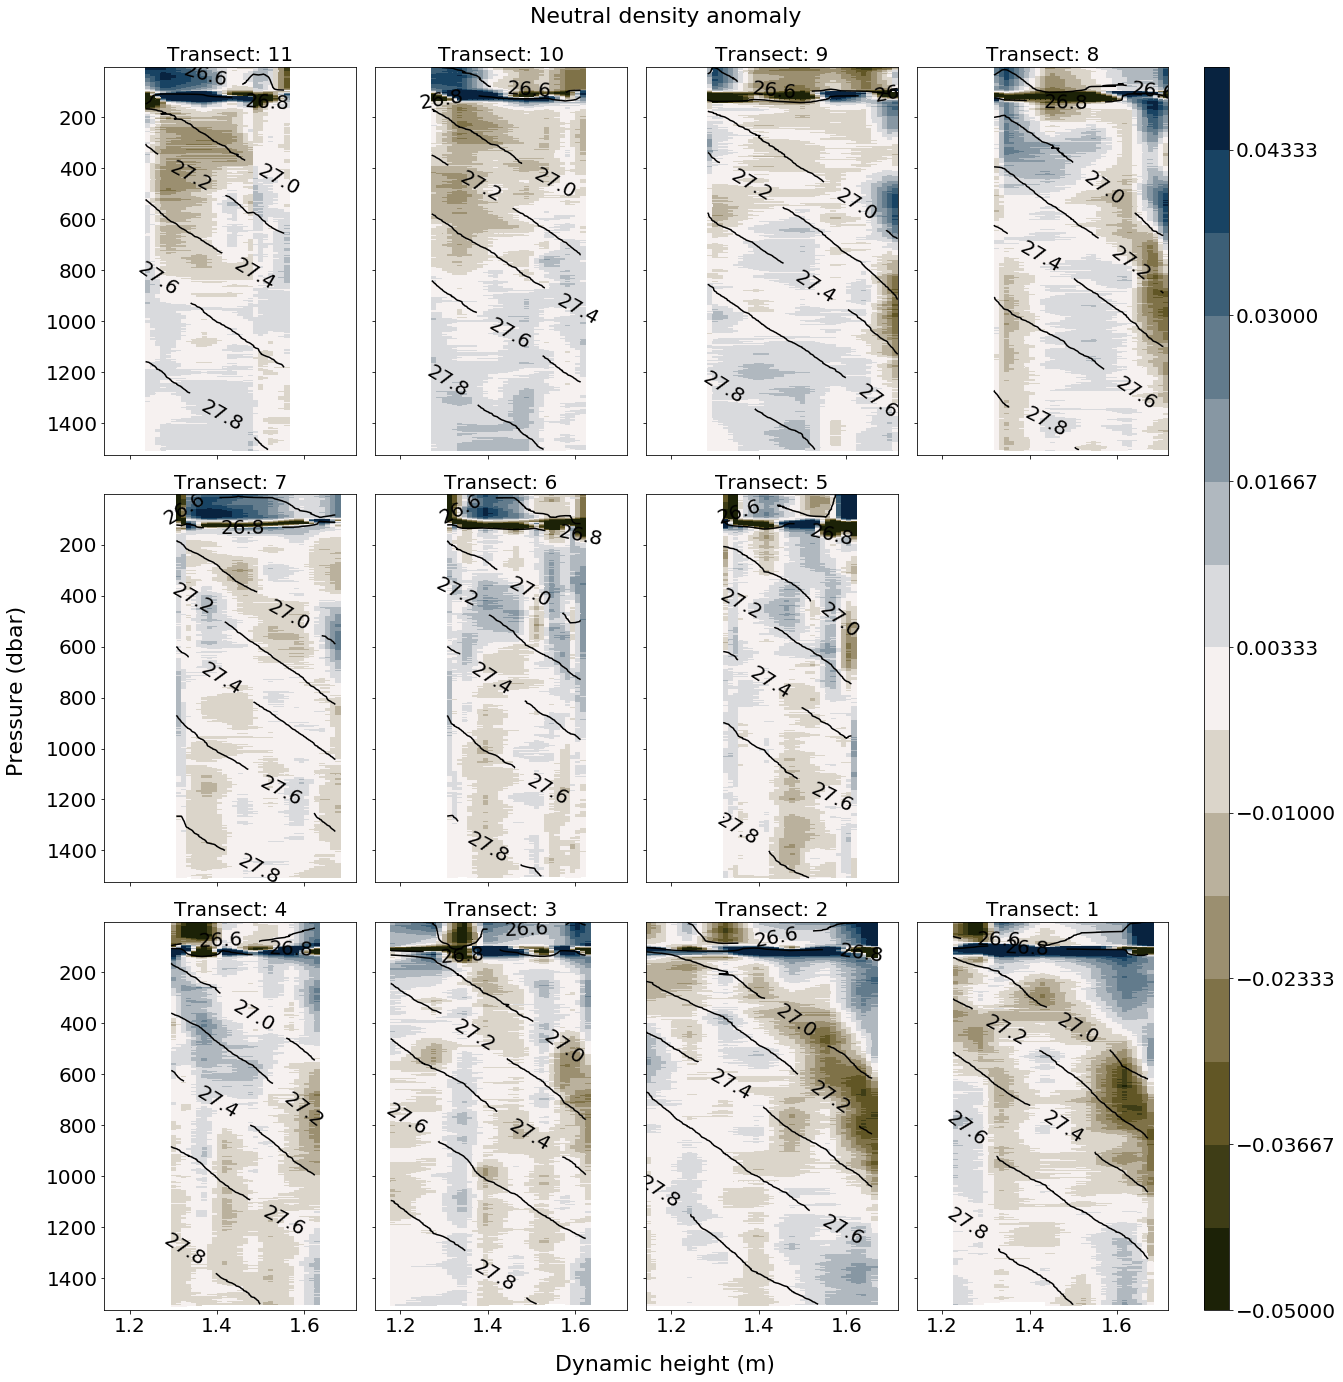

In [9]:
for ivar, var in enumerate(['CT', 'SA', 'gamman']):
    
    anomaly = ctd[var][:] - gem[var][:]
    
    bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
    norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)
    axes[0,0].invert_yaxis()
    for ax, transect in zip(axes.flat, reversed(keys)):
        stations = transects[transect]

        mask = ctd[var][stations].mask | gem[var][stations].mask
        pgrd_ts, Dgrd_ts = np.meshgrid(ctd['p'][:], D[stations])
      
        points = list(zip(Dgrd_ts[~mask].flatten(), pgrd_ts[~mask].flatten()))
        values = anomaly[stations][~mask].flatten()

        # anomaly
        anomaly_interp = griddata(points, values, (Dgrd, pgrd), method='linear')

        # potential and neutral densty surfaces
        gammangrd = griddata(points, ctd['gamman'][stations][~mask].flatten(), (Dgrd, pgrd), method='linear')
#         gammangemgrd = griddata(points, gem['gamman'][stations][~mask].flatten(), (Dgrd, pgrd), method='linear')

        pcol = ax.pcolormesh(Dgrd, pgrd, anomaly_interp, norm=norm, cmap=attr[var][3])

        cont = ax.contour(Dgrd, pgrd, gammangrd, colors='k')
#         cont2 = ax.contour(Dgrd, pgrd, gammangemgrd, colors='k', linestyles='--')

        ax.clabel(cont, inline=1, fontsize=fs_small, fmt='%.1f', inline_spacing=10)
        ax.set_title('Transect: %s' % transect, fontsize=fs_small)

    fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
    fig.delaxes(axes.flat[-5])

    # Set common labels
    fig.text(0.48, 1.02, r'%s anomaly' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
    fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
    fig.text(-0.02, 0.5, r'Pressure (dbar)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

    if savefig:
        fignumber = '04-%s_' % (ivar + 1)
        figname = {'CT': 'conservative-temperature-anomaly', 'SA': 'absolute-salinity-anomaly', 
                    'gamman': 'neutral-density-anomaly'}
        extensions = ['.png', '.pdf', '.eps']
        for extension in extensions:
            fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname[var] + extension), 
                        transparent=True, bbox_inches='tight', pad_inches=1)

## Taylor series of anomaly on pressure and neutral density surfaces

The conservative temperature anomaly on pressure levels between the measurements and the GEM field can be expressed in a Taylor series of the anomaly on neutral density levels (pure warming/ cooling) minus a contribution that consists of the heaving of the isopycnals (pure heaving) $h'$ times the vertical temperature gradient from the GEM field. In this way, water mass transformations can be distinguished from heaving of the isopycnals. Below, the taylor series for conservative temperature is used as an example, but the same holds for absolute salinity.

First, we linear interpolate the conservative temperature field (real and GEM field) from a pressure coordinate system onto a depth ($z$) coordinate system and calculate the vertical gradient of the conservative temperature GEM field,

$$ \Theta(p), \Theta^{GEM}(p) \rightarrow \Theta(z), \Theta^{GEM}(z) $$

$$ \frac{\partial\Theta^{GEM}(z)}{\partial z} $$

Next, we do a similar transformation to a neutral density coordinate system ($\gamma_n$) and we derive the depth of the isopycnals from a transformation of the $\gamma_n$-field,

$$ \Theta(p), \Theta^{GEM}(p) \rightarrow \Theta(\gamma_n), \Theta^{GEM}(\gamma_n) $$

$$ \gamma_n(p), \gamma_n^{GEM}(p), z(p) \rightarrow h(\gamma_n), h^{GEM}(\gamma_n) $$


Then, the Taylor series is described as,
$$\Theta'\left.\right\rvert_{z} = \Theta'\left.\right\rvert_{n} - \left.h' \frac{\partial\Theta}{\partial z}\right\rvert_{n}$$

where,

$$\Theta'\left.\right\rvert_{n} = \Theta(\gamma_n) - \Theta^{GEM}(\gamma_n)$$

$$h'\left.\right\rvert_{n} = h(\gamma_n) - h^{GEM}(\gamma_n)$$.

In order to compare the term on the lhs with the terms on the rhs, a transformation to a mid point $z_m$ between isopycnals is necessary, 

$$ \Theta(z), \Theta^{GEM}(z) \rightarrow \Theta(z_m), \Theta^{GEM}(z_m) $$

$$ \left.\frac{\partial\Theta^{GEM}(z)}{\partial z}\right\rvert_{n} \rightarrow \frac{\partial\Theta^{GEM}}{\partial z} (z_m)$$

such that,

$$\Theta'\left.\right\rvert_{z} = \Theta(z_m) - \Theta^{GEM}(z_m)$$

The mid points on the $z$ coordinate system are defined as

$$ z_m = \frac{h(\gamma_n) + h^{GEM}(\gamma_n)}{2} $$

In [10]:
from scipy.interpolate import interp1d

def interp(xp, yp, xi):
    
    xp = np.ma.masked_invalid(xp)
    yp = np.ma.masked_invalid(yp)
    
    mask = xp.mask | yp.mask
        
    f = interp1d(xp[~mask], yp[~mask], bounds_error=False)
    
    return f(xi)


# transformation 1: from p to z
z = np.ma.masked_invalid(ctd['z'])
zi = np.linspace(z.max(), z.min(), ctd['p'].size)
zgrd = np.broadcast_to(zi, ctd['z'].shape)

CT_z = np.ma.masked_all(ctd['CT'].shape)
# # CT_gem_z, dCTdz_gem_z, gn_z, gn_gem_z = CT_z.copy(), CT_z.copy(), CT_z.copy(), CT_z.copy()
CT_gem_z, gamman_z = CT_z.copy(), CT_z.copy()
for i in range(len(ctd['station'])):
    CT_z[i,] = interp(ctd['z'][i,], ctd['CT'][i,], zi)
    CT_gem_z[i,] = interp(ctd['z'][i,], gem['CT'][i,], zi) if i != 34 else np.nan * np.ones(zi.shape)
    gamman_z[i,] = interp(ctd['z'][i,], ctd['gamman'][i,], zi)
    
# #     dCTdz_z[i,] = interp(ctd['z'][i,], dCTdz[i,], zi) if i != 34 else np.nan * np.ones(zi.shape)
# #     dCTdz_gem_z[i,] = interp(ctd['z'][i,], dCTdz_gem[i,], zi) if i != 34 else np.nan * np.ones(zi.shape)

dCTdz_z = np.gradient(CT_z)[1] / np.gradient(zgrd)[1]
dCTdz_gem_z = np.gradient(CT_gem_z)[1] / np.gradient(zgrd)[1]

CT_prime_z = CT_z - CT_gem_z

# transformation 2: from z to gamman
gn = np.ma.masked_invalid(ctd['gamman'])
gni = np.linspace(gn.min(), gn.max(), ctd['p'].size)

CT_gn = np.ma.masked_all(ctd['CT'].shape)
CT_gem_gn, h_gn, h_gem_gn = CT_gn.copy(), CT_gn.copy(), CT_gn.copy()
for i in range(len(ctd['station'])):
    CT_gn[i,] = interp(ctd['gamman'][i,], ctd['CT'][i,], gni)
    CT_gem_gn[i,] = interp(ctd['gamman'][i,], gem['CT'][i,], gni) if i != 34 else np.nan * np.ones(zi.shape)

    h_gn[i,] = interp(ctd['gamman'][i,], ctd['z'][i,], gni)
    h_gem_gn[i,] = interp(gem['gamman'][i,], ctd['z'][i], gni) if i != 34 else np.nan * np.ones(zi.shape)

CT_prime_gn = CT_gn - CT_gem_gn
h_prime_gn = h_gn - h_gem_gn
    
# transformation 3: from z to zm
zm = (h_gn + h_gem_gn) / 2

CT_zm = np.ma.masked_all(ctd['CT'].shape)
CT_gem_zm, dCTdz_zm, dCTdz_gem_zm = CT_zm.copy(), CT_zm.copy(), CT_zm.copy()
for i in range(len(ctd['station'])):
    CT_zm[i,] = interp(zi, CT_z[i,], zm[i,].data)
    CT_gem_zm[i,] = interp(zi, CT_gem_z[i,], zm[i,].data) if i != 34 else np.nan * np.ones(zi.shape)

    dCTdz_zm[i,] = interp(zi, dCTdz_z[i,], zm[i,].data)
    dCTdz_gem_zm[i,] = interp(zi, dCTdz_gem_z[i,], zm[i,].data) if i != 34 else np.nan * np.ones(zi.shape)

CT_prime_zm = CT_zm - CT_gem_zm


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


### Anomaly of Conservative Temperature in vertical coordinate system (z)

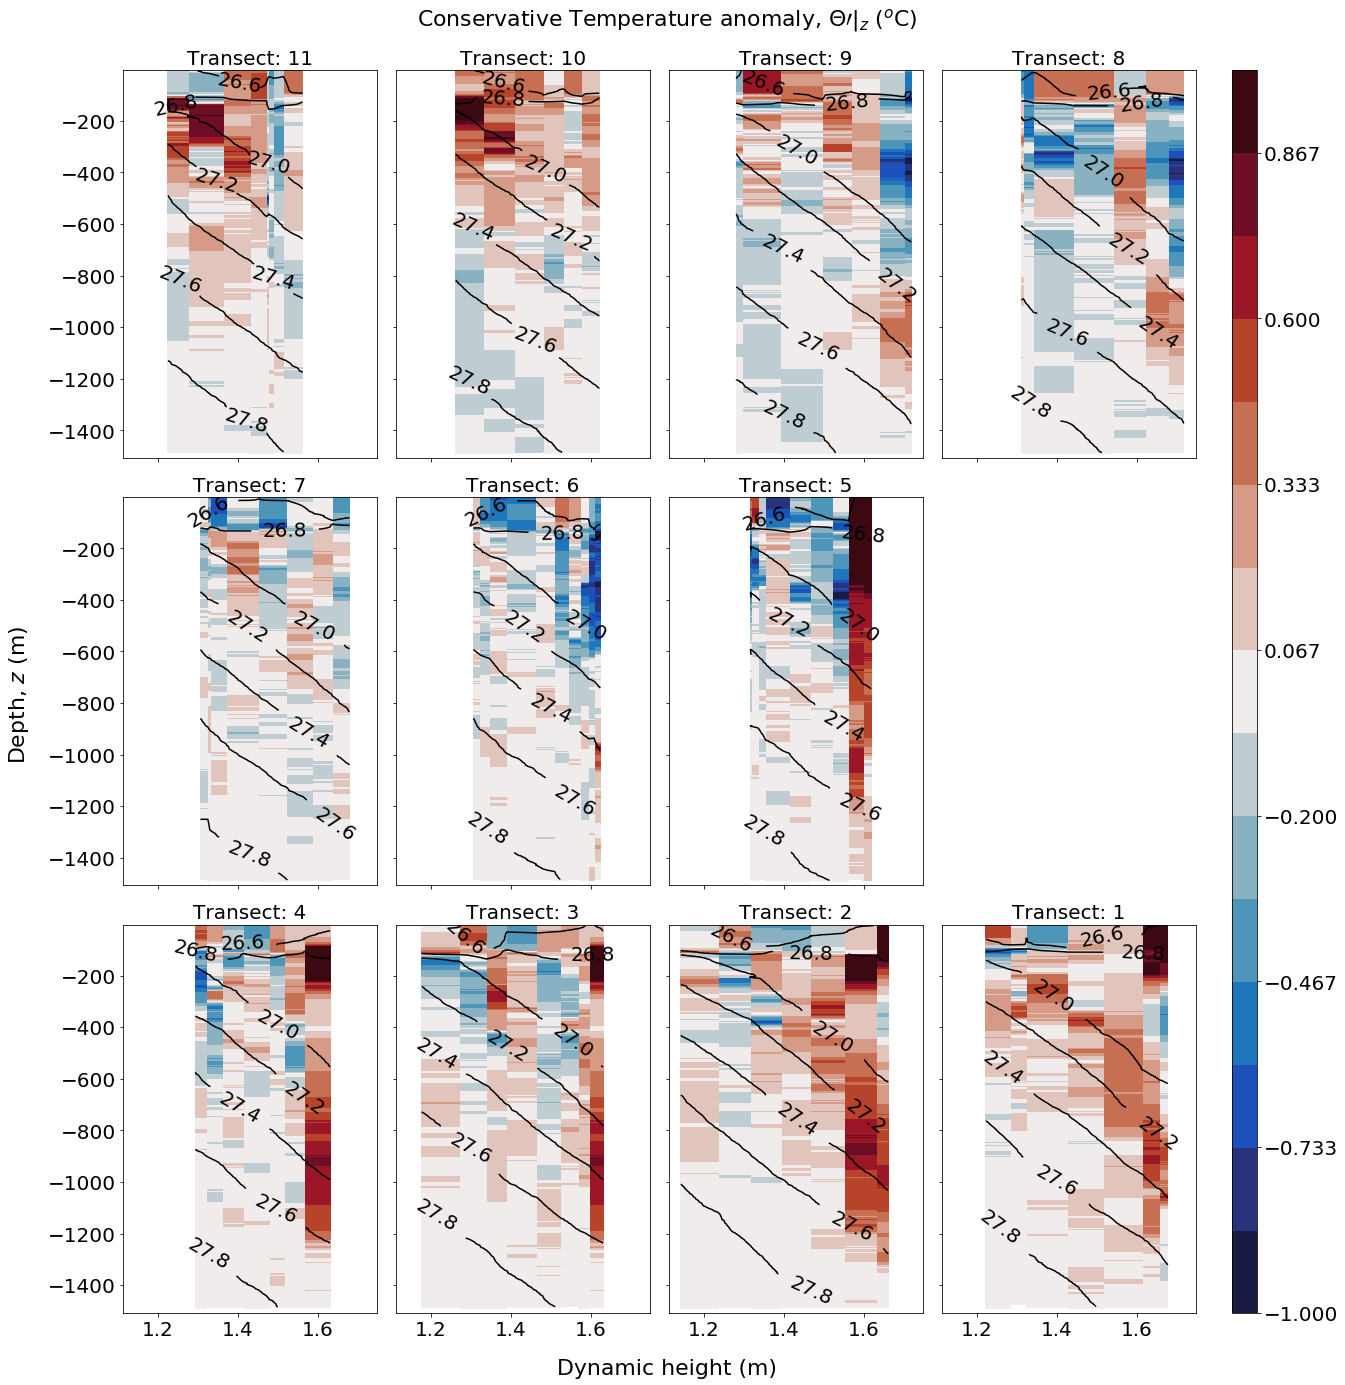

In [11]:
# odds = [0, 1, 8, 9, 10, 11, 26, 44, 45, 46, 74, 75, 76, 77, 100]
var = 'CT'

bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)

for ax, transect in zip(axes.flat, reversed(keys)):
    stations = transects[transect]
#     stations = [x for x in stations if x not in odds]
    
    pcol = ax.pcolormesh(D[stations], zi, CT_prime_z[stations].T, norm=norm, cmap=attr[var][3])
    
    mask = gamman_z[stations].mask
    zz, DD = np.meshgrid(zi, D[stations])
    points = list(zip(DD[~mask].flatten(), zz[~mask].flatten()))
    values = gamman_z[stations][~mask].flatten()
    gamman_z_grd = griddata(points, values, (DD, zz), method='linear')

    cont = ax.contour(DD, zz, gamman_z_grd, colors='k')
    ax.clabel(cont, inline=1, fontsize=fs_small, fmt='%.1f', inline_spacing=10)

    ax.set_title('Transect: %s' % transect, fontsize=fs_small)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-5])

# Set common labels
fig.text(0.48, 1.02, r'%s anomaly, $\left.\Theta\prime\right|_{z}$ ($^o$C)' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Depth, $z$ (m)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

if savefig:
    fignumber = {'CT': '04-1_', 'SA': '04-2_', 'gamman': '04-3_'}
    figname = {'CT': 'conservative-temperature-anomaly-z', 'SA': 'absolute-salinity-anomaly-z', 
                'gamman': 'neutral-density-anomaly-z'}
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber[var] + figname[var] + extension), 
                    transparent=True, bbox_inches='tight', pad_inches=1)

### Anomaly of Conservative Temperature on neutral density surfaces (first term Taylor expansion)

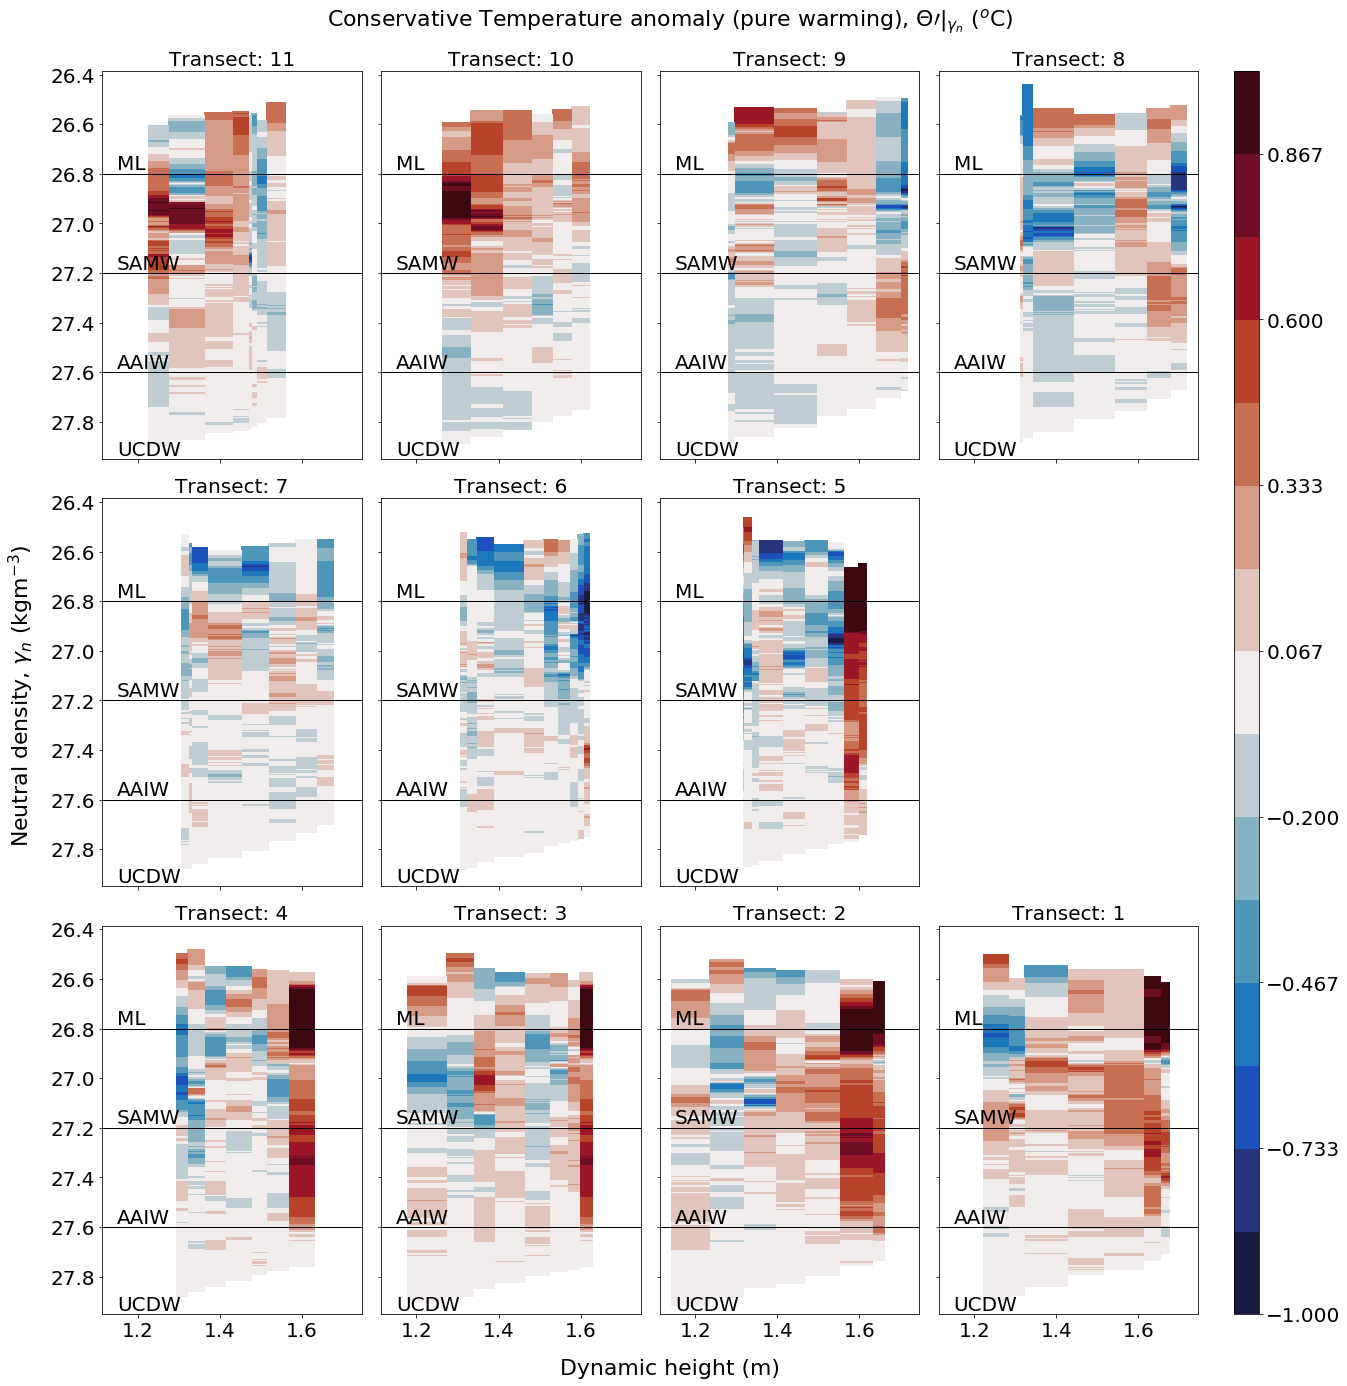

In [12]:
bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

layers = {'ML': 26.8, 'SAMW': 27.2, 'AAIW': 27.6, 'UCDW': 27.95}

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)

axes[0,0].invert_yaxis()

for ax, transect in zip(axes.flat, reversed(keys)):
    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], gni, CT_prime_gn[stations].T, 
                         norm=norm, cmap=attr[var][3])
    for layer in layers.keys():
        if layer is not 'UCDW':
            ax.axhline(layers[layer], linewidth=1, color='k')
        ax.text(1.15, layers[layer], layer, va='bottom', fontsize=fs_small)
        
    ax.set_title('Transect: %s' % transect, fontsize=fs_small)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-5])

# Set common labels
fig.text(0.48, 1.02, r'%s anomaly (pure warming), $\left.\Theta\prime\right|_{\gamma_n}$ ($^o$C)' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

if savefig:
    fignumber = {'CT': '05-1_', 'SA': '05-2_', 'gamman': '05-3_'}
    figname = {'CT': 'conservative-temperature-anomaly-warming', 'SA': 'absolute-salinity-anomaly-warming', 
                'gamman': 'neutral-density-anomaly-warming'}
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber[var] + figname[var] + extension), 
                    transparent=True, bbox_inches='tight', pad_inches=1)

### Heaving of neutral density surfaces (second term Taylor expansion)

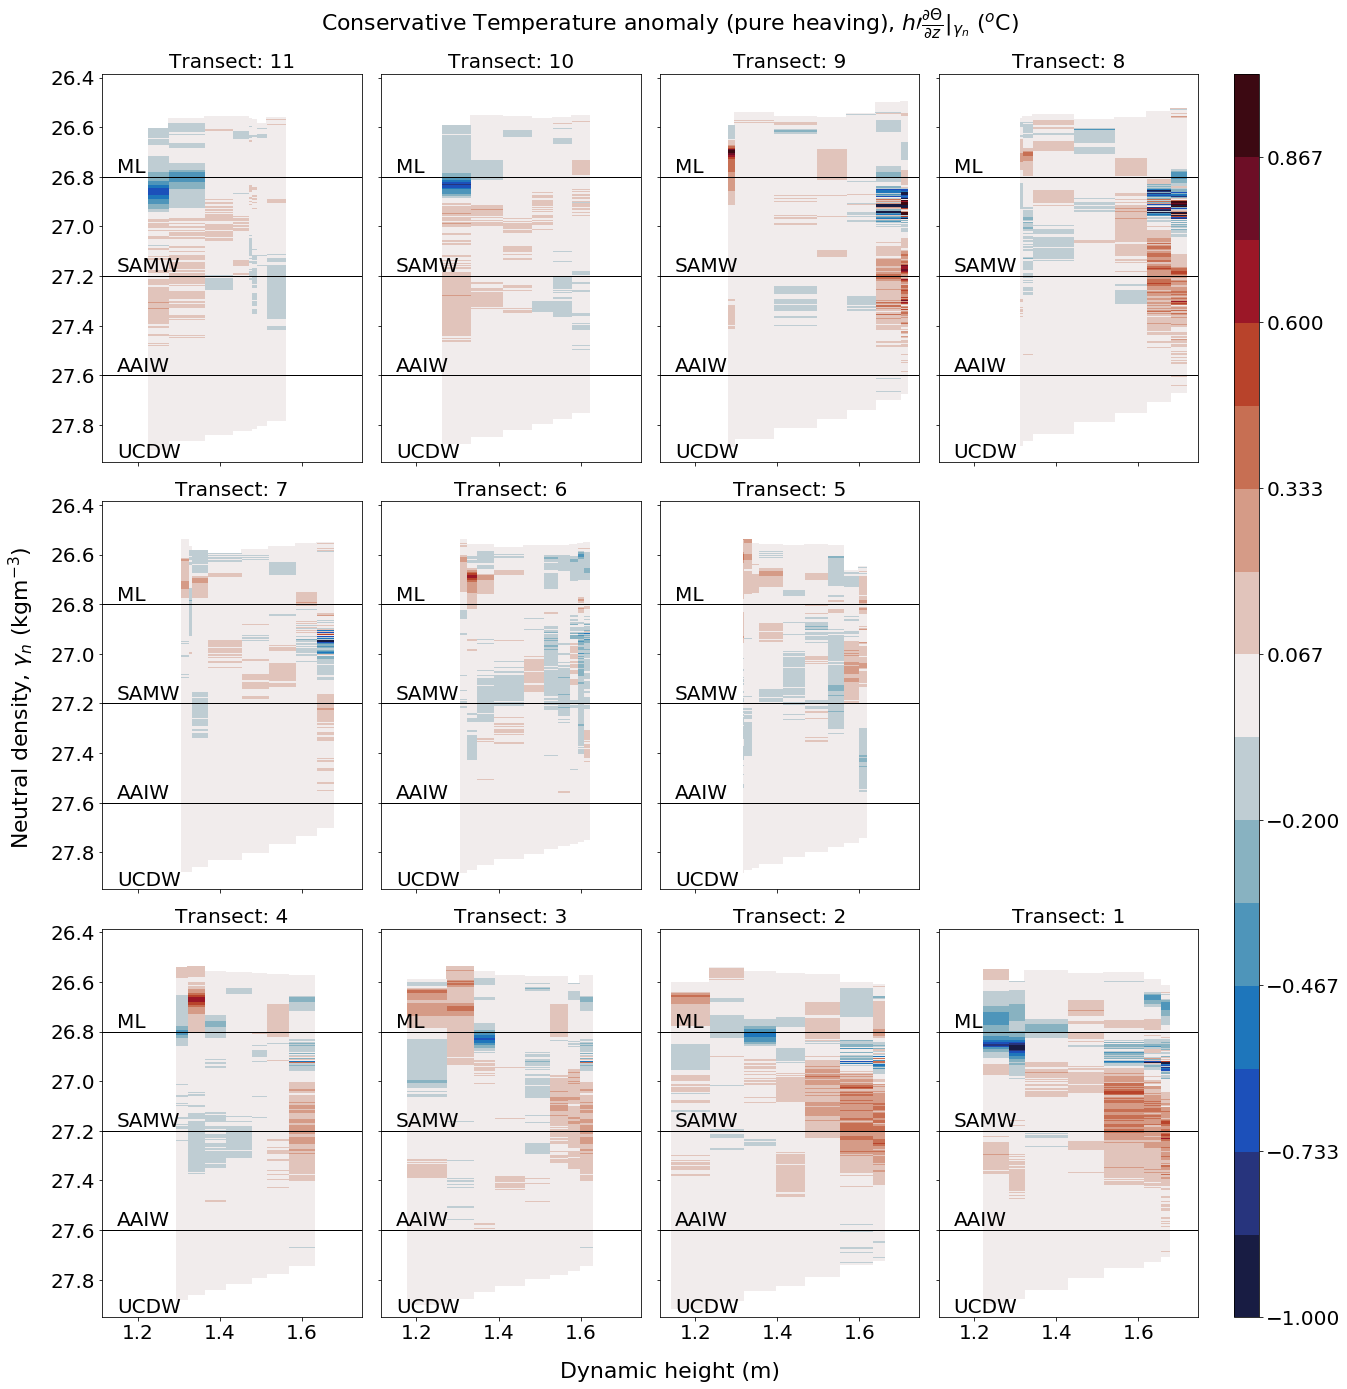

In [13]:
bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)

axes[0,0].invert_yaxis()
for ax, transect in zip(axes.flat, reversed(keys)):
    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], gni, -(h_prime_gn[stations] * dCTdz_gem_zm[stations]).T, 
                         norm=norm, cmap=attr[var][3])
#     pcol = ax.pcolormesh(D[stations], gni, h_mid_gn[stations].T, norm=norm, cmap=cmap)
    
    for layer in layers.keys():
        if layer is not 'UCDW':
            ax.axhline(layers[layer], linewidth=1, color='k')
        ax.text(1.15, layers[layer], layer, va='bottom', fontsize=fs_small)
        
    ax.set_title('Transect: %s' % transect, fontsize=fs_small)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-5])


# Set common labels
fig.text(0.48, 1.02, r'%s anomaly (pure heaving), $\left.h\prime\frac{\partial\Theta}{\partial z}\right|_{\gamma_n}$ ($^o$C)' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

if savefig:
    fignumber = {'CT': '06-1_', 'SA': '06-2_', 'gamman': '06-3_'}
    figname = {'CT': 'conservative-temperature-anomaly-heaving', 'SA': 'absolute-salinity-anomaly-heaving', 
                'gamman': 'neutral-density-anomaly-heaving'}
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber[var] + figname[var] + extension), 
                    transparent=True, bbox_inches='tight', pad_inches=1)

### Difference between LHS and RHS of the Taylor series

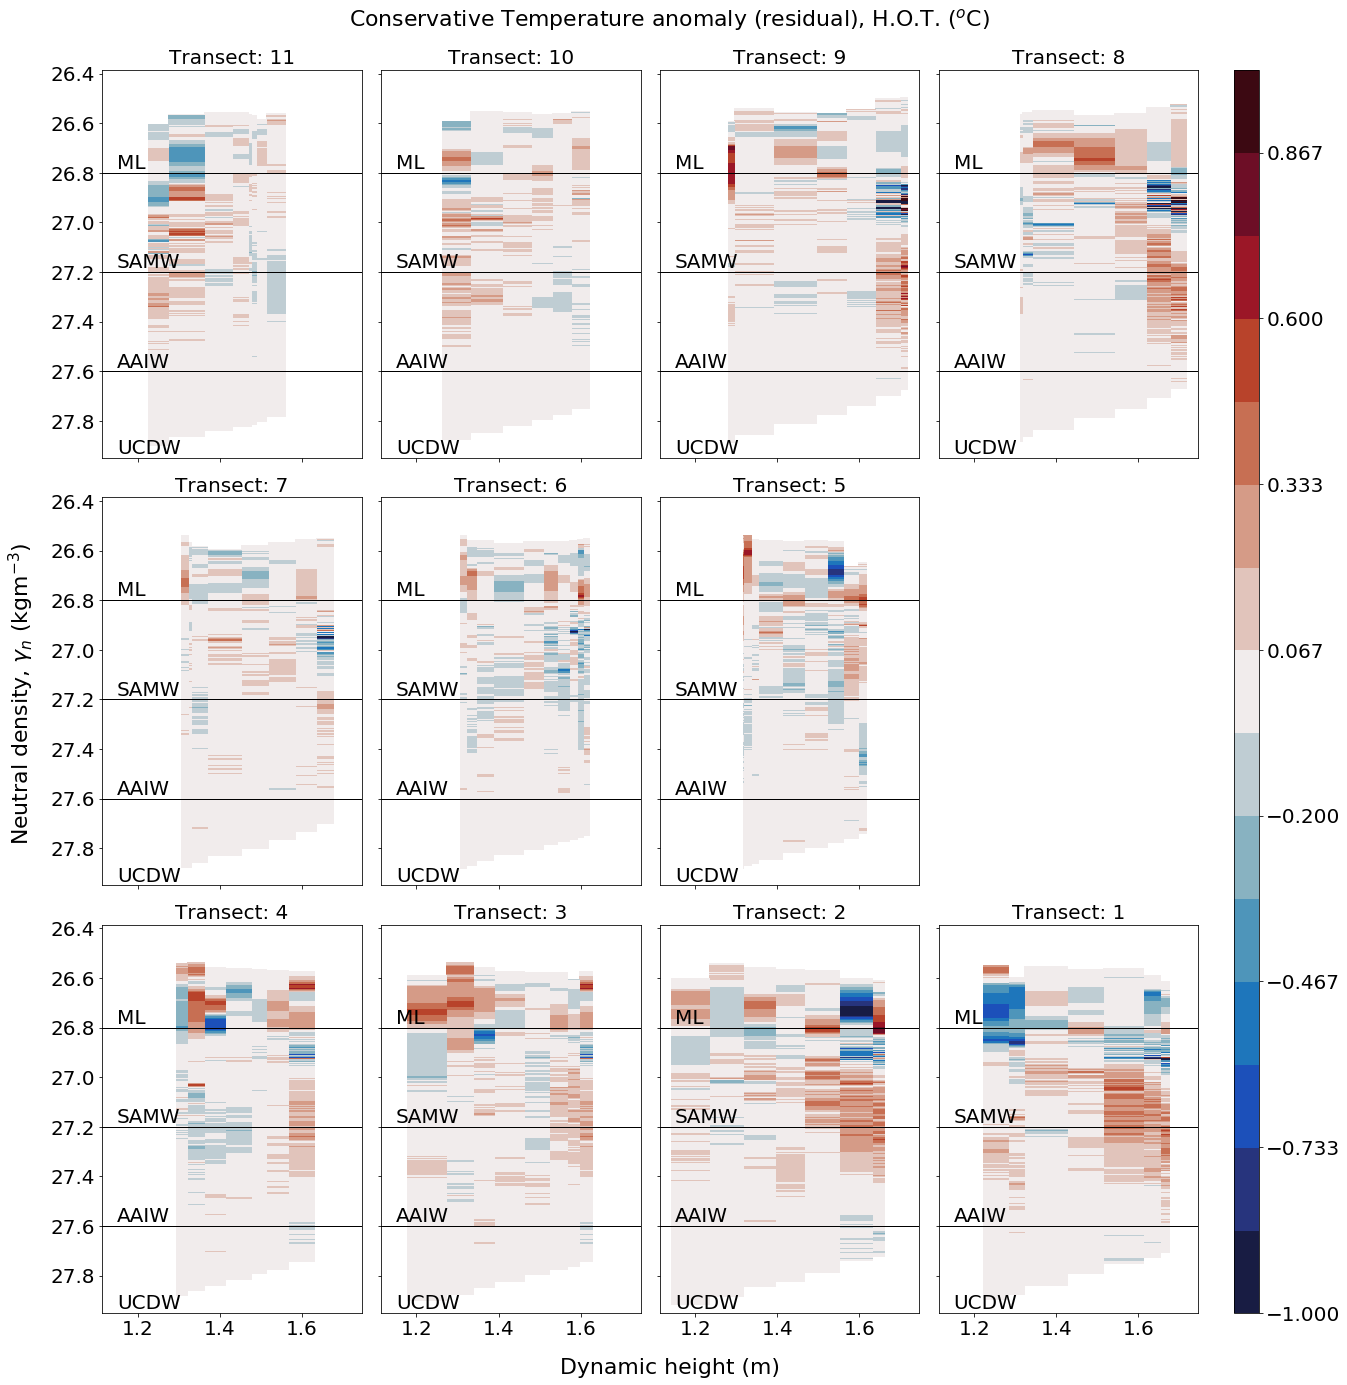

In [14]:
bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)
axes[0,0].invert_yaxis()

for ax, transect in zip(axes.flat, reversed(keys)):
    stations = transects[transect]
    
    lhs = CT_prime_zm[stations]
    rhs = CT_prime_gn[stations] + (h_prime_gn[stations] * dCTdz_gem_zm[stations])
#     rhs = CT_prime_gn[stations] - 0.5 * h_prime_gn[stations] * (dCTdz_zm[stations] + dCTdz_gem_zm[stations])

    pcol = ax.pcolormesh(D[stations], gni, 
                         (lhs - rhs).T,
                         norm=norm, cmap=attr[var][3])

    for layer in layers.keys():
        if layer is not 'UCDW':
            ax.axhline(layers[layer], linewidth=1, color='k')
        ax.text(1.15, layers[layer], layer, va='bottom', fontsize=fs_small)

    ax.set_title('Transect: %s' % transect, fontsize=fs_small)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-5])

# Set common labels
fig.text(0.48, 1.02, r'%s anomaly (residual), H.O.T. ($^o$C)' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

if savefig:
    fignumber = '04_'
    figname = {'CT': 'conservative-temperature-anomaly-residual', 'SA': 'absolute-salinity-anomaly-residual', 
                'gamman': 'neutral-density-anomaly-residual'}
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname[var] + extension), 
                    transparent=True, bbox_inches='tight', pad_inches=1)

### Height difference of neutral density surfaces

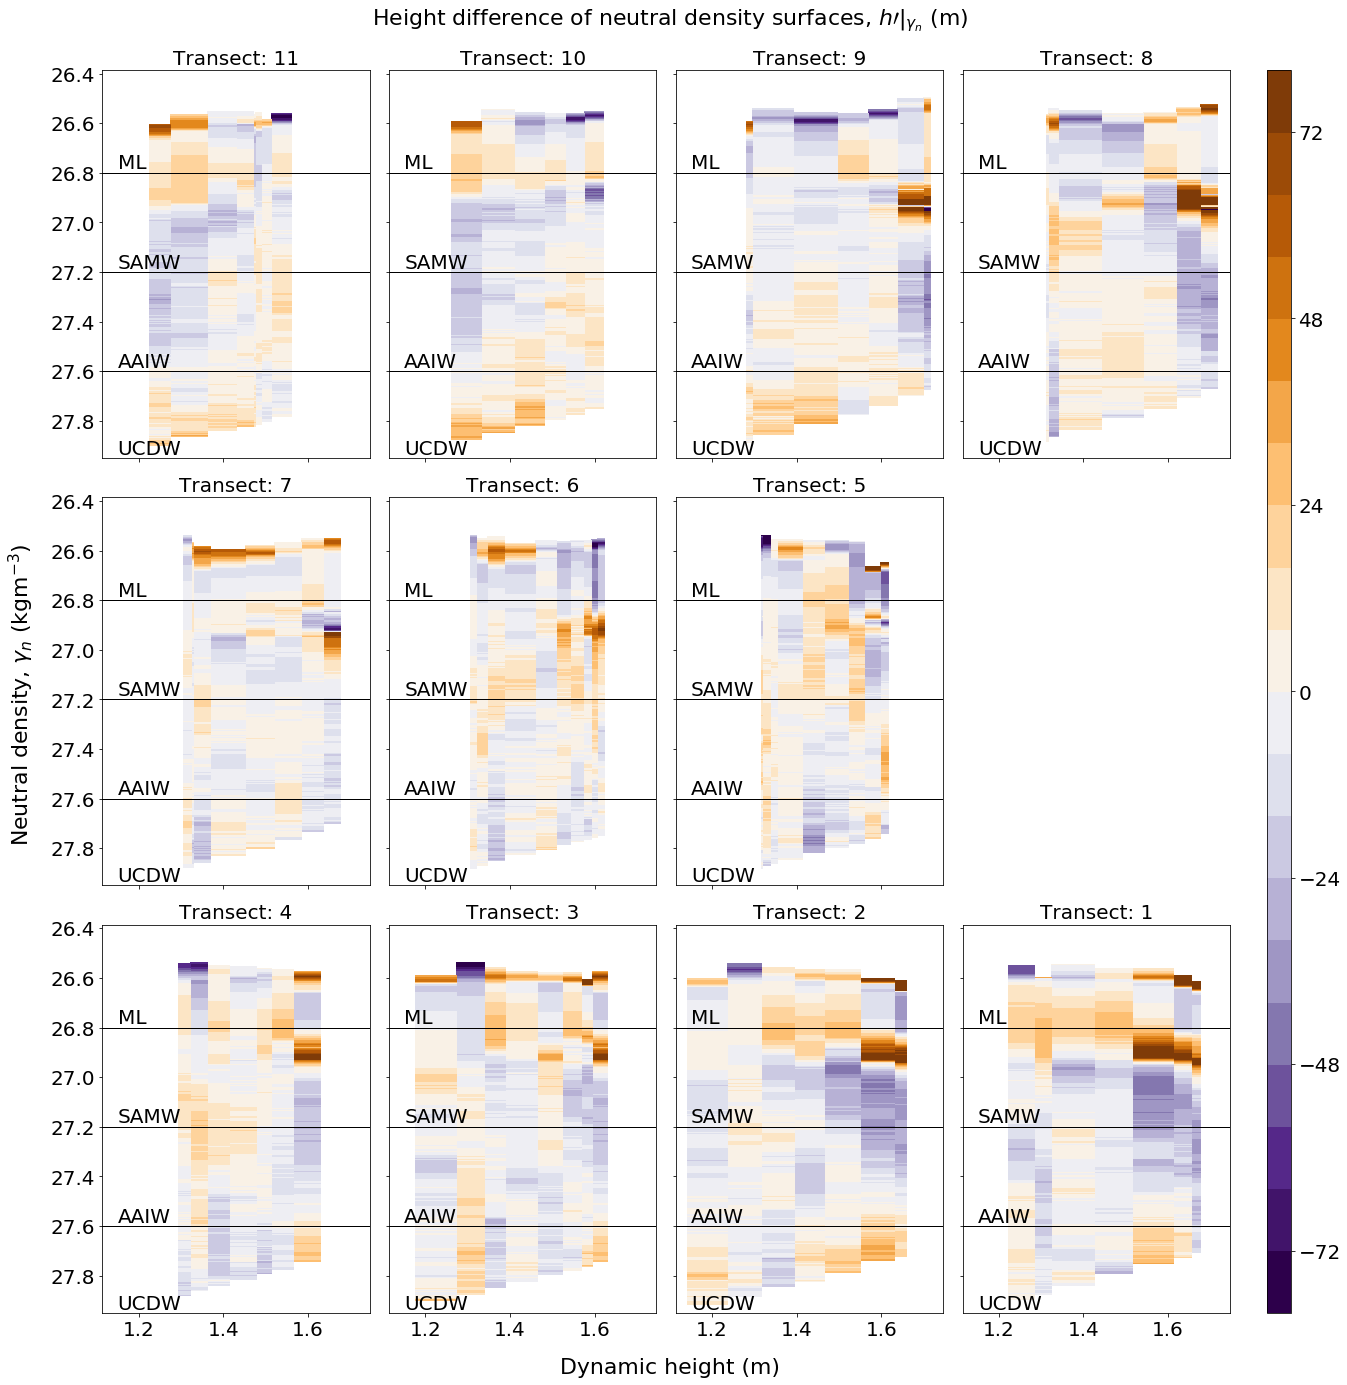

In [15]:
cmap = plt.cm.PuOr_r#cmo.cm.tarn_r
bounds = np.linspace(-80, 80, 21)
# cmap=cmo.cm.deep
# bounds = np.linspace(-1500, 0, 16)

norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)
axes[0,0].invert_yaxis()

for ax, transect in zip(axes.flat, reversed(keys)):
    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], gni, h_prime_gn[stations].T, norm=norm, cmap=cmap)
#     pcol = ax.pcolormesh(D[stations], gni, h_mid_gn[stations].T, norm=norm, cmap=cmap)

    for layer in layers.keys():
        if layer is not 'UCDW':
            ax.axhline(layers[layer], linewidth=1, color='k')
        ax.text(1.15, layers[layer], layer, va='bottom', fontsize=fs_small)

    ax.set_title('Transect: %s' % transect, fontsize=fs_small)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-5])

# Set common labels
fig.text(0.48, 1.02, r'Height difference of neutral density surfaces, $\left.h\prime\right|_{\gamma_n}$ (m)', ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

if savefig:
    fignumber = '06_'
    figname = 'height-difference-heaving'
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname + extension), transparent=True)

## Horizontal anomaly in temperature

In [19]:
# from scipy.interpolate import interp1d

gamman_int_upper = 27.2 # 27.4 #
gamman_int_lower = 27.7 # 27.6 #

anomaly = ctd[var][:] - gem[var][:]
anomaly_int = []
for ist in range(ctd.dimensions['profile'].size):
    idx_u = (np.abs(gn[ist] - gamman_int_upper)).argmin()
    idx_l = (np.abs(gn[ist] - gamman_int_lower)).argmin()
    anomaly_int.append(np.mean(anomaly[ist, idx_u:idx_l]))
anomaly_int = np.array(anomaly_int)


anomaly_hor = np.ma.masked_all((len(transects.keys()),) + Di.shape)
for its, transect in enumerate(transects.keys()):
    stations = transects[transect]
    
    fD = interp1d(D[stations], anomaly_int[stations], bounds_error=False)
    anomaly_hor[its,:] = fD(Di)
    
tsgrd, Dgrd = np.meshgrid(np.arange(1, len(transects.keys()) + 1), Di)


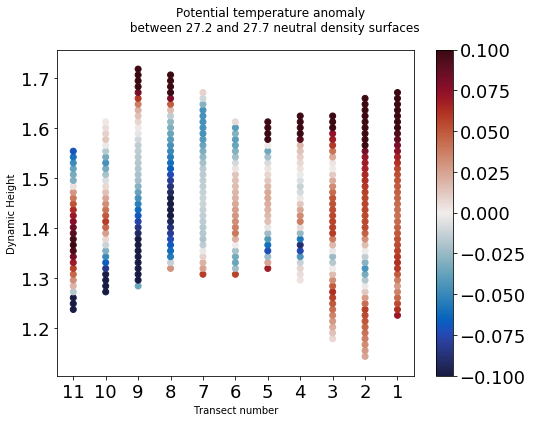

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
scat = ax.scatter(tsgrd, Dgrd, c=anomaly_hor.T, cmap=attr[var][3], vmin=-1, vmax=1)
ax.invert_xaxis()
ax.set_xticks(np.arange(1, len(transects.keys()) + 1))
fig.colorbar(scat)

fig.suptitle('Potential temperature anomaly \n between %s and %s neutral density surfaces' 
          % (gamman_int_upper, gamman_int_lower))
ax.set_xlabel('Transect number')
ax.set_ylabel('Dynamic Height')

if savefig:
    fignumber = '07_'
    figname = 'hor-temperature-anomaly'
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname + extension))

In [8]:
from OceanPy.stability import layer_depth

In [9]:
# create gamman grid/ coordinate system
gamman = np.ma.masked_invalid(ctd['gamman'])
gammani = np.linspace(gamman.min(), gamman.max(), ctd['p'].size)
gammangrd = np.broadcast_to(gammani, Dgrd.T.shape).T 

# calculate anomaly with resepect to GEM
var = 'CT'
anomaly = ctd[var][:] - gem[var][:]

# calculate difference in density layer depth with respect to GEM
gamman_mono, z = layer_depth(ctd['gamman'], ctd['z'])
gamman_mono_gem, z_gem = layer_depth(gem['gamman'], ctd['z'])
gammangrd_mono = np.broadcast_to(gamman_mono, Dgrd.T.shape).T 

# calculate vertical temperature gradient
dTdz = np.gradient(gem[var][:])[1] / np.gradient(ctd['z'][:])[1]
# dTdz = np.gradient(anomaly)[1] / np.gradient(ctd['z'][:])[1]


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


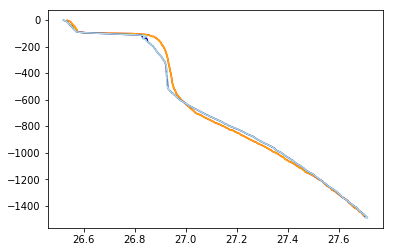

In [10]:
# %matplotlib notebook
plt.plot(gamman_mono, z[74], 'r')
plt.plot(ctd['gamman'][74], ctd['z'][74], 'orange')

plt.plot(gamman_mono_gem, z_gem[74], 'navy')
plt.plot(gem['gamman'][74], ctd['z'][74], 'lightblue')

### Anomaly on neutral density surfaces

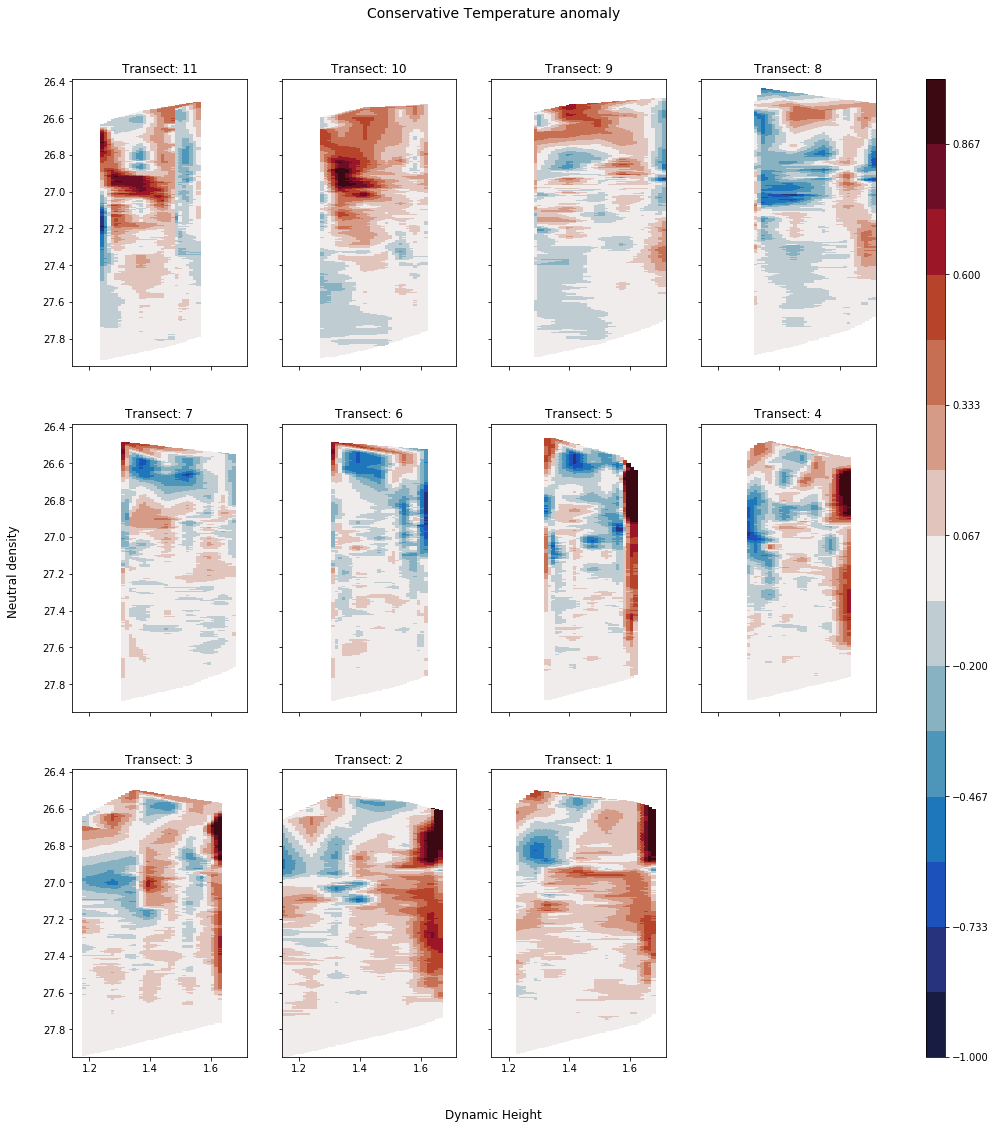

In [11]:
bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True)

for ax, transect in zip(axes.flat, reversed(list(transects.keys()))):
    stations = transects[transect]
    
    mask = anomaly[stations].mask
    
    Dgrd_ts = np.broadcast_to(D[stations], gamman[stations].T.shape).T
    gammangrd_ts = gamman[stations]

    points = list(zip(Dgrd_ts[~mask].flatten(), gammangrd_ts[~mask].flatten()))
    values = anomaly[stations][~mask].flatten()

    anomaly_interp = griddata(points, values, (Dgrd, gammangrd), method='linear')

    pcol = ax.pcolormesh(Dgrd, gammangrd, anomaly_interp, norm=norm, cmap=attr[var][3])

    ax.invert_yaxis()
    ax.set_title('Transect: %s' % transect)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-1])

# Set common labels
fig.text(0.45, 0.93, attr[var][0] + ' anomaly', ha='center', va='center', fontsize=14)
fig.text(0.45, 0.08, 'Dynamic Height', ha='center', va='center', fontsize=12)
fig.text(0.08, 0.5, 'Neutral density', ha='center', va='center', rotation='vertical', fontsize=12)

if savefig:
    fignumber = {'CT': '05-1_', 'SA': '05-2_', 'gamman': '05-3_'}
    figname = {'CT': 'conservative-temperature-anomaly-gamman', 'SA': 'absolute-salinity-anomaly-gamman', 
                'gamman': 'neutral-density-anomaly-gamman'}
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber[var] + figname[var] + extension))

### Heaving of neutral density surfaces

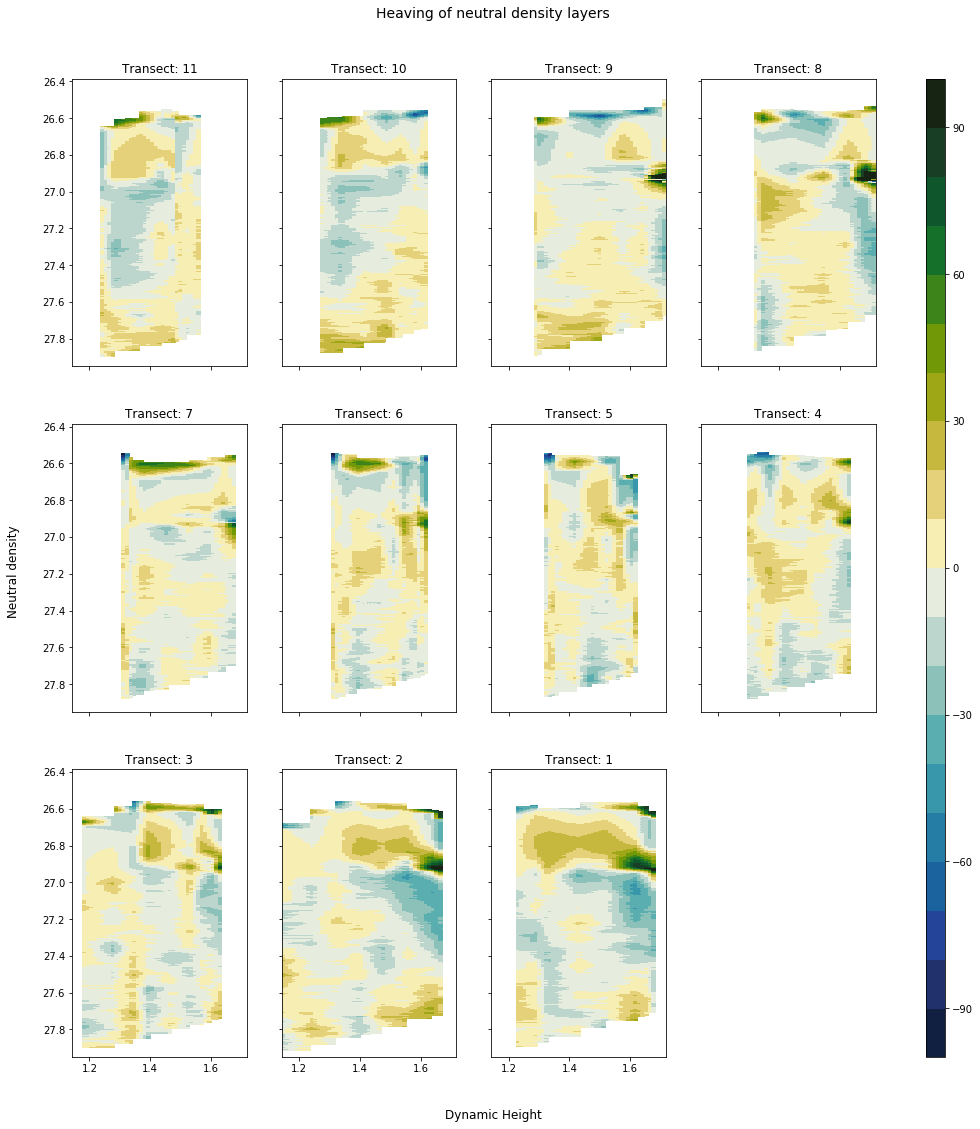

In [12]:
gamman_int_upper = 26.8 # 27.4 #
gamman_int_lower = 26.95 # 27.6 #

cmap = cmo.cm.delta
bounds = np.linspace(-100, 100, 21)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True)
for ax, transect in zip(axes.flat, reversed(list(transects.keys()))):
    stations = transects[transect]

    Dgrd_ts = np.broadcast_to(D[stations], gamman[stations].T.shape).T

    # interpolate density layer depth anomaly on neutral density grid
    mask = z[stations].mask
    gammangrd_ts = np.broadcast_to(gamman_mono, gamman[stations].shape)
    points = list(zip(Dgrd_ts[~mask].flatten(), gammangrd_ts[~mask].flatten()))
    values = z[stations][~mask].flatten()
    z_interp = griddata(points, values, (Dgrd, gammangrd), method='linear')

    mask = z_gem[stations].mask
    gammangrd_ts = np.broadcast_to(gamman_mono_gem, gamman[stations].shape)
    points = list(zip(Dgrd_ts[~mask].flatten(), gammangrd_ts[~mask].flatten()))
    values = z_gem[stations][~mask].flatten()
    z_gem_interp = griddata(points, values, (Dgrd, gammangrd), method='linear')   
    
    dz_interp = z_interp - z_gem_interp
    pcol = ax.pcolormesh(Dgrd, gammangrd, dz_interp, norm=norm, cmap=cmap)

    ax.invert_yaxis()
    ax.set_title('Transect: %s' % transect)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-1])


# Set common labels
fig.text(0.45, 0.93, 'Heaving of neutral density layers', ha='center', va='center', fontsize=14)
fig.text(0.45, 0.08, 'Dynamic Height', ha='center', va='center', fontsize=12)
fig.text(0.08, 0.5, 'Neutral density', ha='center', va='center', rotation='vertical', fontsize=12)

if savefig:
    fignumber = '06_'
    figname = 'heaving-neutral-density'
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname + extension))

### Vertical temperature anomaly gradient 

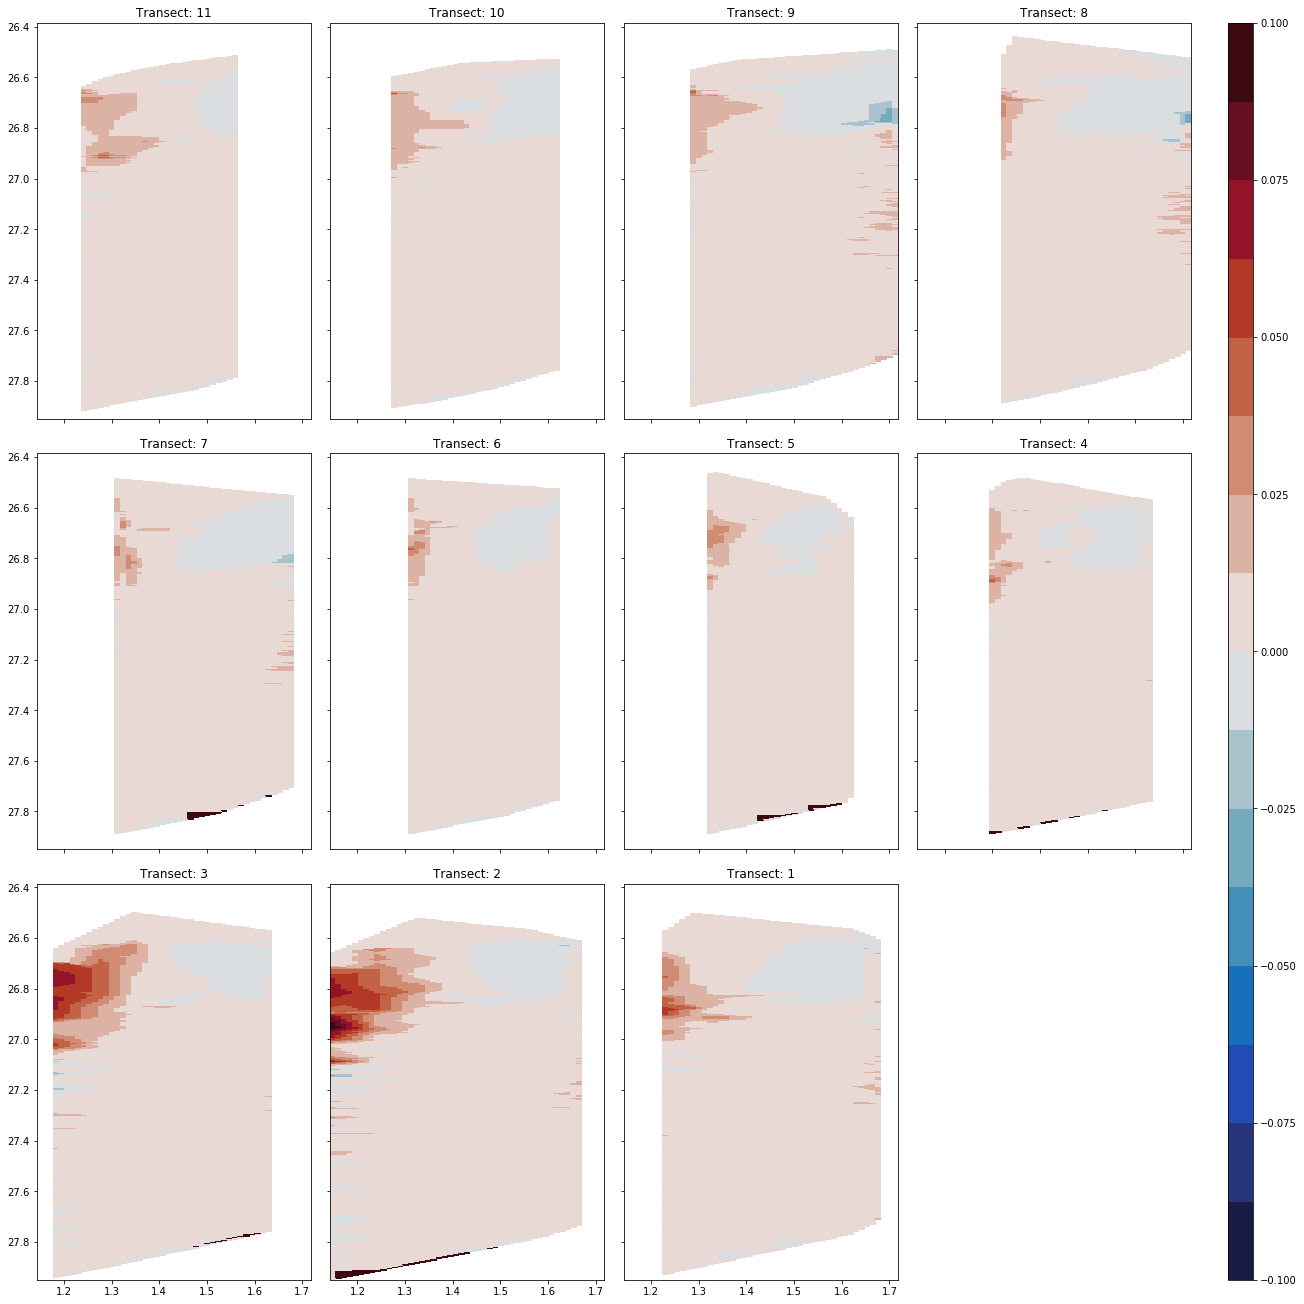

In [13]:
cmap = plt.cm.viridis
bounds = np.linspace(-0.10, 0.10, 17)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)

for ax, transect in zip(axes.flat, reversed(list(transects.keys()))):
    stations = transects[transect]
    
    mask = gamman[stations].mask | gem[var][stations].mask
    
    Dgrd_ts = np.broadcast_to(D[stations], gamman[stations].T.shape).T
    gammangrd_ts = gamman[stations]

    points = list(zip(Dgrd_ts[~mask].flatten(), gammangrd_ts[~mask].flatten()))
    values = dTdz[stations][~mask].flatten()

    dTdz_interp = griddata(points, values, (Dgrd, gammangrd), method='linear')

    pcol = ax.pcolormesh(Dgrd, gammangrd, dTdz_interp, norm=norm, cmap=attr[var][3])

    ax.invert_yaxis()
    ax.set_title('Transect: %s' % transect)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-1])

### Taylor series

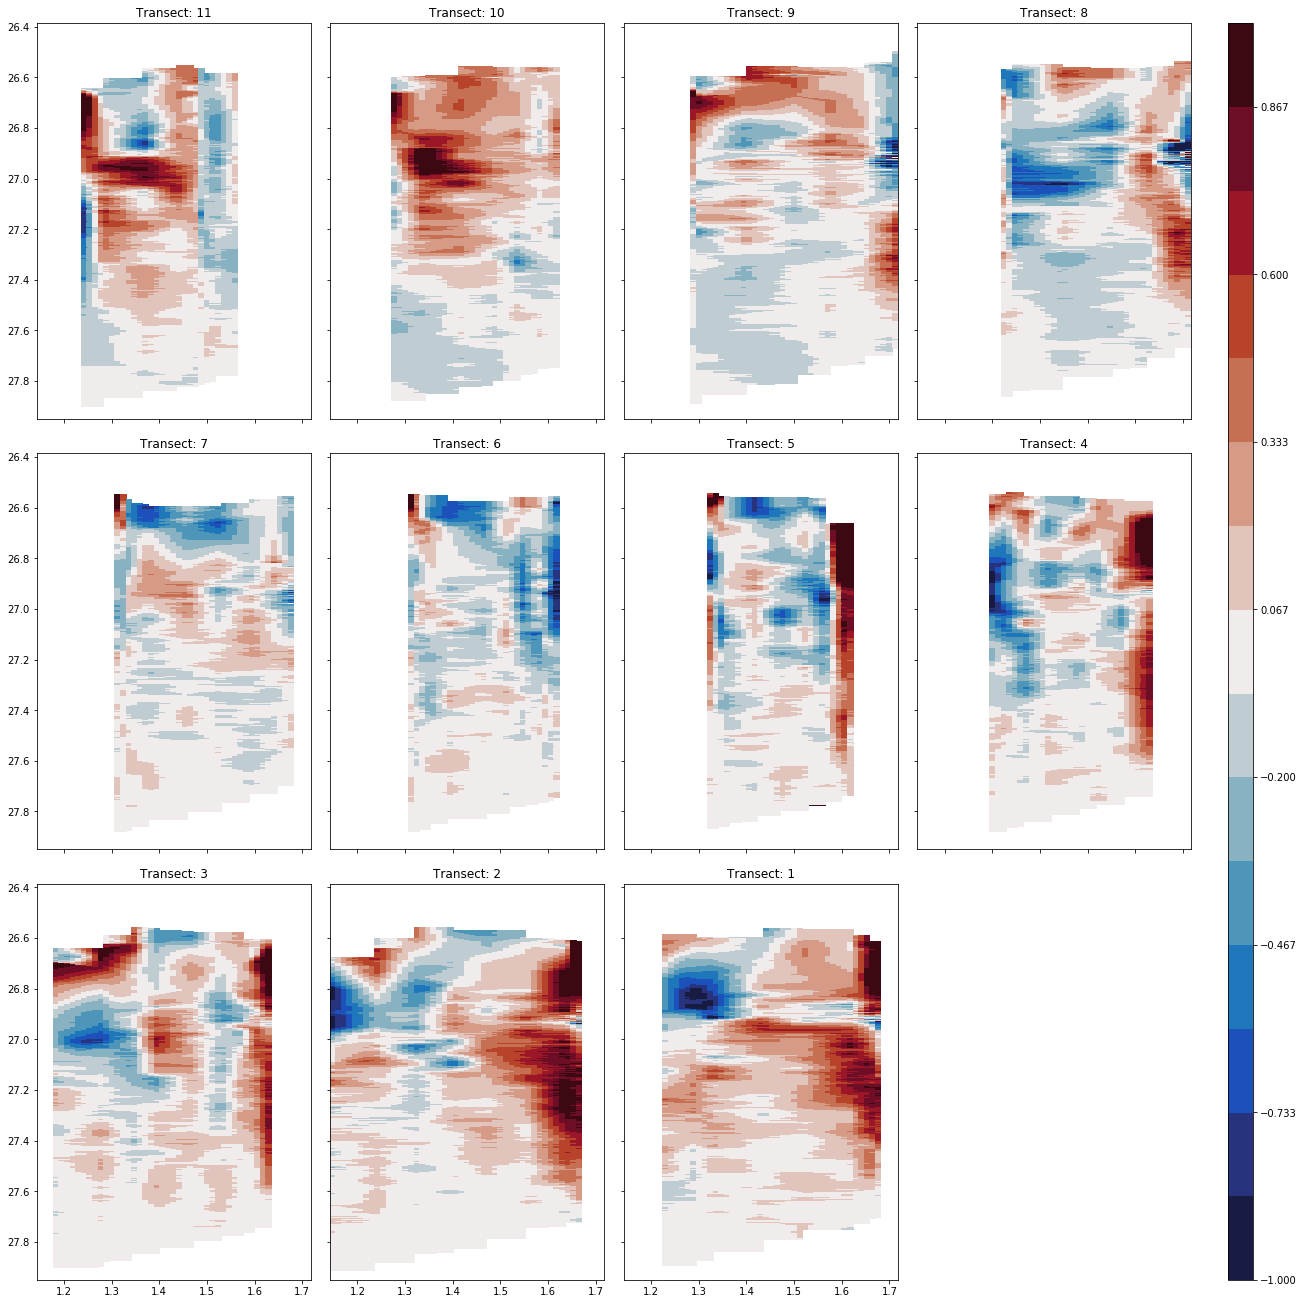

In [14]:
bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)
for ax, transect in zip(axes.flat, reversed(list(transects.keys()))):

    stations = transects[transect]
    Dgrd_ts = np.broadcast_to(D[stations], gamman[stations].T.shape).T

    # interpolate temperature anomaly on neutral density grid
    mask = ctd[var][stations].mask | gem[var][stations].mask
    gammangrd_ts = gamman[stations]
    points = list(zip(Dgrd_ts[~mask].flatten(), gammangrd_ts[~mask].flatten()))
    values = anomaly[stations][~mask].flatten()
    anomaly_interp = griddata(points, values, (Dgrd, gammangrd), method='linear')
    
    # interpolate density layer depth anomaly on neutral density grid
    mask = z[stations].mask
    gammangrd_ts = np.broadcast_to(gamman_mono, gamman[stations].shape)
    points = list(zip(Dgrd_ts[~mask].flatten(), gammangrd_ts[~mask].flatten()))
    values = z[stations][~mask].flatten()
    z_interp = griddata(points, values, (Dgrd, gammangrd), method='linear')

    mask = z_gem[stations].mask
    gammangrd_ts = np.broadcast_to(gamman_mono_gem, gamman[stations].shape)
    points = list(zip(Dgrd_ts[~mask].flatten(), gammangrd_ts[~mask].flatten()))
    values = z_gem[stations][~mask].flatten()
    z_gem_interp = griddata(points, values, (Dgrd, gammangrd), method='linear')   
    
    dz_interp = z_interp - z_gem_interp
    
    # interpolate vertical temperature gradient on neutral density grid
    mask = ctd[var][:][stations].mask | ctd['z'][:][stations].mask
    gammangrd_ts = gamman[stations]
    points = list(zip(Dgrd_ts[~mask].flatten(), gammangrd_ts[~mask].flatten()))
    values = dTdz[stations][~mask].flatten()
    dTdz_interp = griddata(points, values, (Dgrd, gammangrd), method='linear')
    
    # interpolate taylor expansion on pressure grid
    taylor_exp = anomaly_interp - (dz_interp * dTdz_interp)
    
    pcol = ax.pcolormesh(Dgrd, gammangrd, taylor_exp,
                         norm=norm, cmap=attr[var][3])
    
    ax.invert_yaxis()
    ax.set_title('Transect: %s' % transect)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-1])

